In [1]:
%matplotlib inline
import matplotlib.pyplot as plt


In [2]:
import pandas as pd 
import numpy as np
import calendar

from datetime import datetime, date, timedelta
from math import sqrt


In [3]:
#Pull latest data from binance 

import ccxt
exchange_class = getattr(ccxt, 'binance')
binance  = exchange_class()


def min_ohlcv(dt, pair, limit):
    # UTC native object
    since = calendar.timegm(dt.utctimetuple())*1000
    ohlcv1 = binance.fetch_ohlcv(symbol=pair, timeframe='1m', since=since, limit=limit)
    ohlcv2 = binance.fetch_ohlcv(symbol=pair, timeframe='1m', since=since, limit=limit)
    ohlcv = ohlcv1 + ohlcv2
    return ohlcv

def ohlcv(dt, pair, period='1d'):
    ohlcv = []
    limit = 1000
    if period == '1m':
        limit = 720
    elif period == '1d':
        limit = 365
    elif period == '1h':
        limit = 24
    elif period == '5m':
        limit = 288
    for i in dt:
        start_dt = datetime.strptime(i, "%Y%m%d")
        since = calendar.timegm(start_dt.utctimetuple())*1000
        if period == '1m':
            ohlcv.extend(min_ohlcv(start_dt, pair, limit))
        else:
            ohlcv.extend(binance.fetch_ohlcv(symbol=pair, timeframe=period, since=since, limit=limit))
    df = pd.DataFrame(ohlcv, columns = ['Time', 'Open', 'High', 'Low', 'Close', 'Volume'])
    df['Time'] = [datetime.fromtimestamp(float(time)/1000) for time in df['Time']]
    df['Open'] = df['Open'].astype(np.float64)
    df['High'] = df['High'].astype(np.float64)
    df['Low'] = df['Low'].astype(np.float64)
    df['Close'] = df['Close'].astype(np.float64)
    df['Volume'] = df['Volume'].astype(np.float64)
    df.set_index('Time', inplace=True)
    return df

from datetime import datetime, date, timedelta

start_day = "20200101" #"20201201"
start_dt = datetime.strptime(start_day, "%Y%m%d")
end_day = "20220830"
end_dt = datetime.strptime(end_day, "%Y%m%d")
days_num = (end_dt - start_dt).days + 1
datelist = [start_dt + timedelta(days=x) for x in range(days_num)]
datelist = [date.strftime("%Y%m%d") for date in datelist]

#fwd = 10
coin = 'ETH'
pair = coin + "/USDT"

dfName = "prices_all_1m" + start_day + end_day + coin + ".csv"

try : 
    df = pd.read_csv(dfName)
except : 
    df = ohlcv(datelist, pair, '1m')
    df.to_csv(dfName)

In [4]:
# calculations for Perp V2 LP 

def calculateL(pNow, pDeposit, vDeposit ,pLower, pUpper) : 
    if pDeposit < pLower : 
        L = vDeposit / (pDeposit * ( 1 / sqrt(pLower) - 1 / sqrt(pUpper)))
    elif pDeposit > pUpper :
        L = vDeposit / (sqrt(pUpper) - sqrt(pLower) )
    else : 
        L = vDeposit / (pDeposit*(1 / sqrt(pDeposit) - 1 / sqrt(pUpper) ) + sqrt(pDeposit) - sqrt(pLower) )

    return L 

def getYLower(pLower, pUpper, L) :
    return L * sqrt(pLower)

def getXUpper(pLower, pUpper, L) :
    return L / sqrt(pUpper) 
    
def getYMax(pLower, pUpper, L) :
    return (sqrt(pUpper) - sqrt(pLower)) * L 
    
def getXMax(pLower, pUpper, L) : 
    return (1 / sqrt(pLower) - 1 / sqrt(pUpper)) * L 
    
def getXReal(pCurrent, pLower, pUpper, L) : 
    if pCurrent < pLower : 
        X = getXMax(pLower, pUpper, L)
    elif pCurrent > pUpper :
        X = 0
    else : 
        X = (L / sqrt(pCurrent)) - getXUpper(pLower, pUpper, L)
    return X 
    
def getYReal(pCurrent, pLower, pUpper, L) : 
    if pCurrent < pLower : 
        Y = 0
    elif pCurrent > pUpper :
        Y = getYMax(pLower, pUpper, L)
    else : 
        Y = (L * sqrt(pCurrent)) - getYLower(pLower, pUpper, L)

    return Y     
    
def getXLP(pCurrent, pLower, pUpper, L) : 
    return (getXReal(pCurrent, pLower, pUpper, L) * pCurrent)

def getYLP(pCurrent, pLower, pUpper, L) : 
    return (getYReal(pCurrent, pLower, pUpper, L))
    
def getVLP(pCurrent, pLower, pUpper, L) : 
    x = getXLP(pCurrent, pLower, pUpper, L)
    y = getYLP(pCurrent, pLower, pUpper, L)
    return (x + y)



In [5]:
# Strategy paramaters 

lendAllocation = .65
#debt thresholds for rebalancing
debtLow = .975
debtHigh = 1.025
collatLow = .5
collatTarget = .55
collatHigh = .6
slippageAdj = 0.0015 #.005 #when rebalancing losses from swapping 

# APY's
lendRate = .0
borrowRate = .0
lpRewards = 1.1

#SIM INFO
stepsPerYear = 365*24*60 #if simulating hourly set to be 365 * 24 

annualRates = {'lend' : lendRate, 'borrow' : borrowRate, 'lp' : lpRewards}
adjRates = {'lend' : (lendRate/stepsPerYear), 
            'borrow' : (borrowRate/stepsPerYear),
            'lp' : (lpRewards/stepsPerYear)}

# lpRange 
lowRange = 0.5
highRange = 2


In [6]:
# Strategy functions for simulations 

def doRebalance(cRatio, debtRatio) : 
    if cRatio < collatLow : doRebalance = True
    elif cRatio > collatHigh : doRebalance = True
    elif debtRatio < debtLow : doRebalance = True
    elif debtRatio > debtHigh : doRebalance = True
    else : doRebalance = False
    
    return doRebalance


def enterPosition(pNow, depositAmount):
    Collateral = lendAllocation*depositAmount
    Debt = (1 - lendAllocation)*depositAmount
    lpAmount = Debt*2
    DebtX = Debt / pNow
    lpAmount = Debt*2 # we pair equally     
    PLow = lowRange * pNow
    PHigh = highRange * pNow
    PEntry = pNow 
    L = calculateL(pNow, pNow, lpAmount ,PLow, PHigh)
    return (PEntry, Collateral, DebtX, PLow, PHigh, L, lpAmount)

def updatePosition(p, Collateral, DebtX):

    Collateral = Collateral*(1+adjRates['lend'])
    DebtX = DebtX *(1+adjRates['borrow'])
    Debt = DebtX * p
    return Collateral, DebtX, Debt

#def exitPosition

In [7]:
from scipy.stats import sem
nLags = 60*6 
semData = []

for j in range(len(df) - nLags) : 
    endInd = j + nLags
    semData.append(sem(df['Close'][j : endInd] / df['Close'][j : endInd].mean()))
                


In [8]:
percentile = 90
pauseMax = np.percentile(semData, percentile)


In [9]:
# Simulate based on historical market data 
### No Pausing 

PStart = df['Open'].iloc[nLags+1]
depositAmount = 1000000
PEntry, Collateral, DebtX, PLow, PHigh, L, lpAmount = enterPosition(PStart, depositAmount)

maxPortfolio = depositAmount 
minPortfolio = depositAmount

harvestFrequency = 360 
harvestCounter = 0 

portfolioTrack = []
trackFreq = 60*24*30

for i in range(len(df) - nLags - 1) : 
        p = df['Close'].iloc[i + nLags + 1]
        harvestCounter += 1 
        #p = PEntry 
        Collateral, DebtX, Debt = updatePosition(p, Collateral, DebtX)
        
        #Debt = DebtX * p
        L = calculateL(p, PEntry, lpAmount ,PLow, PHigh)        
        # add LP rewards
        L = L *(1+adjRates['lp'])

        # Key Metrics for rebalancing 
        
        CRatio = Debt / Collateral 
        xInLp = getXReal(p, PLow, PHigh, L)
        DebtRatio = xInLp / DebtX
        
        # rebalance LOGIC HERHEHEHREHERHEEH
        rebalance = doRebalance(CRatio, DebtRatio)
        if rebalance == True :
            #print("Rebalance ---- ")
            #print("C Ratio : "  + str(int(CRatio*100)))
            #print("Debt Ratio : "  + str(int(DebtRatio*100)))

            lpValue = getVLP(p, PLow, PHigh, L)
            if DebtRatio < 1 : 
                slippage = (DebtX - xInLp)*p*slippageAdj
            else : 
                slippage = (xInLp - DebtX)*p*slippageAdj
            portFolio = Collateral - Debt + lpValue - slippage 
            
            # we re-enter position with new range 
            PEntry, Collateral, DebtX, PLow, PHigh, L, lpAmount = enterPosition(p, portFolio)
            
        lpValue = getVLP(p, PLow, PHigh, L)
        # PRINT SOME FREE MONEY REEEEEEE
        if harvestCounter > harvestFrequency :
            
            Collateral = Collateral + (lpValue*adjRates['lp']*harvestCounter)
            harvestCounter = 0 
            
        portFolio = Collateral - Debt + lpValue

        maxPortfolio = max(maxPortfolio, portFolio)
        minPortfolio = min(minPortfolio, portFolio)
    
        if i % trackFreq == 0 : 
            print("Iteration Number --- " + str(i))
            print("Price "  + str(int(p)))
            print("Portfolio Value --- " + str(int(portFolio)))
            portfolioTrack.append(portFolio)
            print(" --- " )


Iteration Number --- 0
Price 130
Portfolio Value --- 1000001
 --- 
Iteration Number --- 43200
Price 181
Portfolio Value --- 1040911
 --- 
Iteration Number --- 86400
Price 221
Portfolio Value --- 1060809
 --- 
Iteration Number --- 129600
Price 131
Portfolio Value --- 893216
 --- 
Iteration Number --- 172800
Price 225
Portfolio Value --- 914466
 --- 
Iteration Number --- 216000
Price 231
Portfolio Value --- 942008
 --- 
Iteration Number --- 259200
Price 225
Portfolio Value --- 986810
 --- 
Iteration Number --- 302400
Price 317
Portfolio Value --- 1036241
 --- 
Iteration Number --- 345600
Price 387
Portfolio Value --- 1052430
 --- 
Iteration Number --- 388800
Price 360
Portfolio Value --- 1066813
 --- 
Iteration Number --- 432000
Price 392
Portfolio Value --- 1121063
 --- 
Iteration Number --- 475200
Price 526
Portfolio Value --- 1152703
 --- 
Iteration Number --- 518400
Price 627
Portfolio Value --- 1178446
 --- 
Iteration Number --- 561600
Price 1443
Portfolio Value --- 1089410
 --- 
It

In [10]:
# Simulate based on historical market data 
### With Pausing 

PStart = df['Open'].iloc[nLags+1]
depositAmount = 1000000
PEntry, Collateral, DebtX, PLow, PHigh, L, lpAmount = enterPosition(PStart, depositAmount)

maxPortfolio = depositAmount 
minPortfolio = depositAmount

harvestFrequency = 360 
harvestCounter = 0 

portfolioTrack1 = []
trackFreq = 60*24*30

paused = False 

for i in range(len(df) - nLags - 1) : 
        p = df['Close'].iloc[i + nLags + 1]
        
        if paused == False : 
            harvestCounter += 1 
        #p = PEntry 
        Collateral, DebtX, Debt = updatePosition(p, Collateral, DebtX)
        
        #Debt = DebtX * p
        L = calculateL(p, PEntry, lpAmount ,PLow, PHigh)        
        # add LP rewards
        L = L *(1+adjRates['lp'])

        # Key Metrics for rebalancing 
        
        CRatio = Debt / Collateral 
        xInLp = getXReal(p, PLow, PHigh, L)
        DebtRatio = xInLp / DebtX
        
        # rebalance LOGIC HERHEHEHREHERHEEH
        rebalance = doRebalance(CRatio, DebtRatio)
        if rebalance == True :
            #print("Rebalance ---- ")
            #print("C Ratio : "  + str(int(CRatio*100)))
            #print("Debt Ratio : "  + str(int(DebtRatio*100)))
            if paused == False : 

                lpValue = getVLP(p, PLow, PHigh, L)
                if DebtRatio < 1 : 
                    slippage = (DebtX - xInLp)*p*slippageAdj
                else : 
                    slippage = (xInLp - DebtX)*p*slippageAdj
                portFolio = Collateral - Debt + lpValue - slippage 

                # we re-enter position with new range 
                PEntry, Collateral, DebtX, PLow, PHigh, L, lpAmount = enterPosition(p, portFolio)

        lpValue = getVLP(p, PLow, PHigh, L)
        # PRINT SOME FREE MONEY REEEEEEE
        if harvestCounter > harvestFrequency :
            
            Collateral = Collateral + (lpValue*adjRates['lp']*harvestCounter)
            harvestCounter = 0 
            
        portFolio = Collateral - Debt + lpValue
        
        ### Pause / Unpause 
        
        se = semData[i]
        if se > pauseMax : 
            if paused == False : 
                paused = True 
                if DebtRatio < 1 : 
                    slippage = (DebtX - xInLp)*p*slippageAdj
                else : 
                    slippage = (xInLp - DebtX)*p*slippageAdj
                portFolio = Collateral - Debt + lpValue - slippage 
                Collateral = portFolio
                DebtX = 0
                L = 0
                lpAmount = 0 
            
            
        if se < pauseMax : 
            if paused == True :
                paused = False 
                PEntry, Collateral, DebtX, PLow, PHigh, L, lpAmount = enterPosition(p, portFolio)

        
        
        maxPortfolio = max(maxPortfolio, portFolio)
        minPortfolio = min(minPortfolio, portFolio)
    
        if i % trackFreq == 0 : 
            print("Iteration Number --- " + str(i))
            print("Price "  + str(int(p)))
            print("Portfolio Value --- " + str(int(portFolio)))
            portfolioTrack1.append(portFolio)
            print(" --- " )



Iteration Number --- 0
Price 130
Portfolio Value --- 1000001
 --- 


/tmp/ipykernel_41388/2233402857.py:36: RuntimeWarning: invalid value encountered in double_scalars
  DebtRatio = xInLp / DebtX


Iteration Number --- 43200
Price 181
Portfolio Value --- 1040613
 --- 
Iteration Number --- 86400
Price 221
Portfolio Value --- 1057550
 --- 
Iteration Number --- 129600
Price 131
Portfolio Value --- 1059247
 --- 
Iteration Number --- 172800
Price 225
Portfolio Value --- 1085960
 --- 
Iteration Number --- 216000
Price 231
Portfolio Value --- 1097218
 --- 
Iteration Number --- 259200
Price 225
Portfolio Value --- 1147254
 --- 
Iteration Number --- 302400
Price 317
Portfolio Value --- 1204168
 --- 
Iteration Number --- 345600
Price 387
Portfolio Value --- 1242448
 --- 
Iteration Number --- 388800
Price 360
Portfolio Value --- 1263815
 --- 
Iteration Number --- 432000
Price 392
Portfolio Value --- 1328016
 --- 
Iteration Number --- 475200
Price 526
Portfolio Value --- 1366186
 --- 
Iteration Number --- 518400
Price 627
Portfolio Value --- 1398160
 --- 
Iteration Number --- 561600
Price 1443
Portfolio Value --- 1364203
 --- 
Iteration Number --- 604800
Price 1641
Portfolio Value --- 136837

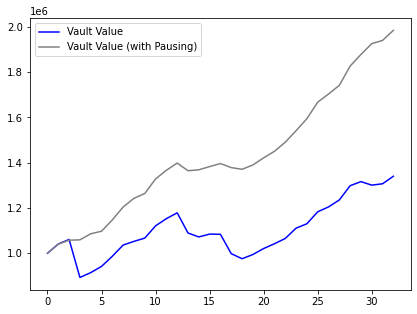

In [11]:
#plt.subplot()

fig = plt.figure()
fig.set_size_inches(15,5)

#fig.subplots_adjust(hspace=1, wspace=1)

ax = fig.add_subplot(1, 2, 1)
ax.plot(portfolioTrack, color = 'blue', label = 'Vault Value' )
ax.plot(portfolioTrack1, color = 'grey', label = 'Vault Value (with Pausing)' )
ax.legend(loc = 'upper left')



plt.show()

In [12]:
(portfolioTrack1[-1] - depositAmount)/ (portfolioTrack[-1] - depositAmount)

2.8948529677012944

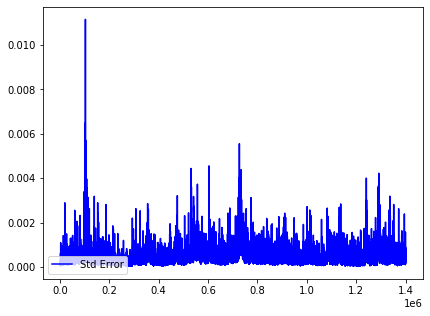

In [13]:
fig = plt.figure()
fig.set_size_inches(15,5)

#fig.subplots_adjust(hspace=1, wspace=1)

ax = fig.add_subplot(1, 2, 1)
ax.plot(semData, color = 'blue', label = 'Std Error' )
ax.legend(loc = 'lower left')



plt.show()

In [28]:
from scipy.stats.stats import pearsonr


np.corrcoef(semData[nLags:],semData[0: -nLags])

/tmp/ipykernel_41388/2320655291.py:1: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


array([[1.       , 0.2854885],
       [0.2854885, 1.       ]])

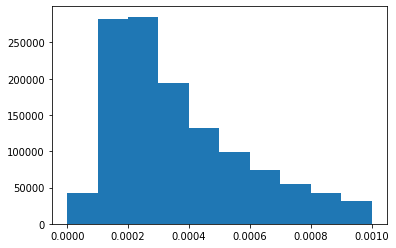

In [26]:
plt.hist(semData, bins = [0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006,0.0007, 0.0008, .0009, .001])
plt.show()

In [14]:
def sim() : 
    PStart = df['Open'].iloc[nLags+1]
    depositAmount = 1000000
    PEntry, Collateral, DebtX, PLow, PHigh, L, lpAmount = enterPosition(PStart, depositAmount)

    maxPortfolio = depositAmount 
    minPortfolio = depositAmount
    maxDrawdown = 0

    harvestFrequency = 360 
    harvestCounter = 0 

    portfolioTrack1 = []
    trackFreq = 60*24*30

    paused = False 

    for i in range(len(df) - nLags - 1) : 
            p = df['Close'].iloc[i + nLags + 1]

            if paused == False : 
                harvestCounter += 1 
            #p = PEntry 
            Collateral, DebtX, Debt = updatePosition(p, Collateral, DebtX)

            #Debt = DebtX * p
            L = calculateL(p, PEntry, lpAmount ,PLow, PHigh)        
            # add LP rewards
            L = L *(1+adjRates['lp'])

            # Key Metrics for rebalancing 

            CRatio = Debt / Collateral 
            xInLp = getXReal(p, PLow, PHigh, L)
            DebtRatio = xInLp / DebtX

            # rebalance LOGIC HERHEHEHREHERHEEH
            rebalance = doRebalance(CRatio, DebtRatio)
            if rebalance == True :
                #print("Rebalance ---- ")
                #print("C Ratio : "  + str(int(CRatio*100)))
                #print("Debt Ratio : "  + str(int(DebtRatio*100)))
                if paused == False : 

                    lpValue = getVLP(p, PLow, PHigh, L)
                    if DebtRatio < 1 : 
                        slippage = (DebtX - xInLp)*p*slippageAdj
                    else : 
                        slippage = (xInLp - DebtX)*p*slippageAdj
                    portFolio = Collateral - Debt + lpValue - slippage 

                    # we re-enter position with new range 
                    PEntry, Collateral, DebtX, PLow, PHigh, L, lpAmount = enterPosition(p, portFolio)

            lpValue = getVLP(p, PLow, PHigh, L)
            # PRINT SOME FREE MONEY REEEEEEE
            if harvestCounter > harvestFrequency :

                Collateral = Collateral + (lpValue*adjRates['lp']*harvestCounter)
                harvestCounter = 0 

            portFolio = Collateral - Debt + lpValue

            ### Pause / Unpause 

            se = semData[i]
            if se > pauseMax : 
                if paused == False : 
                    paused = True 
                    if DebtRatio < 1 : 
                        slippage = (DebtX - xInLp)*p*slippageAdj
                    else : 
                        slippage = (xInLp - DebtX)*p*slippageAdj
                    portFolio = Collateral - Debt + lpValue - slippage 
                    Collateral = portFolio
                    DebtX = 0
                    L = 0
                    lpAmount = 0 


            if se < pauseMax : 
                if paused == True :
                    paused = False 
                    PEntry, Collateral, DebtX, PLow, PHigh, L, lpAmount = enterPosition(p, portFolio)



            maxPortfolio = max(maxPortfolio, portFolio)
            minPortfolio = min(minPortfolio, portFolio)
            
            drawdown = 1 - (portFolio / maxPortfolio)
            maxDrawdown = max(drawdown, maxDrawdown)

            if i % trackFreq == 0 : 
                #print("Iteration Number --- " + str(i))
                #print("Price "  + str(int(p)))
                #print("Portfolio Value --- " + str(int(portFolio)))
                portfolioTrack1.append(portFolio)
                #print(" --- " )

    return portFolio, maxDrawdown

In [29]:
###
### Optimise for multiple paramaters ###

pauseLagDiff = 240 
pauseLagsNumber = 5 

debtRateDiff = 0.015 
debtRatioNumber = 8 

pauseLagPerc = 5
pauseLagPercNumber = 4 

### storage variables 

pauseLagStore = []
debtLowStore = []
debtHighStore = []
pauseLagPercStore = []
portfolioEndStore = []
drawdownStore = []
simCount = 1

for j in range(pauseLagsNumber) :
    
    nLags = pauseLagDiff*(j+1) 
    semData = []
    print("Calc SE")
    for X in range(len(df) - nLags) : 
        endInd = X + nLags
        semData.append(sem(df['Close'][X : endInd] / df['Close'][X : endInd].mean()))
                    
    print("SE Calculated")
    for k in range(debtRatioNumber) : 
        
        debtLow = 1 - (k+1)*debtRateDiff
        debtHigh = 1 + (k+1)*debtRateDiff
        
        for l in range(pauseLagPercNumber) : 

            percentile = 100 - (l)*pauseLagPerc
            pauseMax = np.percentile(semData, percentile)            
            
            print("Start Sim --- # " +str(simCount))
            portFolio, drawdown = sim()
            
            simCount += 1 
            print("End Sim")
            pauseLagStore.append(nLags)
            debtLowStore.append(debtLow)
            debtHighStore.append(debtHigh)
            pauseLagPercStore.append(percentile)
            portfolioEndStore.append(portFolio)
            drawdownStore.append(drawdown)
            print("Ending Value : " + str(portFolio))
            print("Max Drawdown : " + str(drawdown))


Calc SE
SE Calculated
Start Sim --- # 1
End Sim
Ending Value : 1289623.9387340476
Max Drawdown : 0.2535215788008339
Start Sim --- # 2


/tmp/ipykernel_41388/2631823830.py:35: RuntimeWarning: invalid value encountered in double_scalars
  DebtRatio = xInLp / DebtX


End Sim
Ending Value : 1732493.9151105382
Max Drawdown : 0.13060104557544538
Start Sim --- # 3
End Sim
Ending Value : 1804526.7338272152
Max Drawdown : 0.1279601756639409
Start Sim --- # 4
End Sim
Ending Value : 1961314.4922195612
Max Drawdown : 0.10408730121129062
Start Sim --- # 5
End Sim
Ending Value : 1398982.1424736178
Max Drawdown : 0.26302747552614436
Start Sim --- # 6
End Sim
Ending Value : 1863232.2486782386
Max Drawdown : 0.1333158178979461
Start Sim --- # 7
End Sim
Ending Value : 1911004.4724733573
Max Drawdown : 0.12927191251708448
Start Sim --- # 8
End Sim
Ending Value : 2212833.7107297657
Max Drawdown : 0.11004726002016219
Start Sim --- # 9
End Sim
Ending Value : 1498380.4021089636
Max Drawdown : 0.25027265692753253
Start Sim --- # 10
End Sim
Ending Value : 1925931.7312810088
Max Drawdown : 0.1362337599187079
Start Sim --- # 11
End Sim
Ending Value : 1992245.130201779
Max Drawdown : 0.13602588206412336
Start Sim --- # 12
End Sim
Ending Value : 2182845.1767197573
Max Drawd

End Sim
Ending Value : 2691952.1412799405
Max Drawdown : 0.08252144563933039
Start Sim --- # 89
End Sim
Ending Value : 1882827.5144288654
Max Drawdown : 0.30849542076859504
Start Sim --- # 90
End Sim
Ending Value : 2936842.3457929734
Max Drawdown : 0.12221008152755897
Start Sim --- # 91
End Sim
Ending Value : 3018945.2739769183
Max Drawdown : 0.10276152113937709
Start Sim --- # 92
End Sim
Ending Value : 2939965.1260045506
Max Drawdown : 0.08124284553576377
Start Sim --- # 93
End Sim
Ending Value : 2006980.4246562673
Max Drawdown : 0.2907612309976434
Start Sim --- # 94
End Sim
Ending Value : 3011380.0432614386
Max Drawdown : 0.12398680844400023
Start Sim --- # 95
End Sim
Ending Value : 3190942.935872553
Max Drawdown : 0.13988075225541174
Start Sim --- # 96
End Sim
Ending Value : 3019093.4937688415
Max Drawdown : 0.08693553151900912
Calc SE
SE Calculated
Start Sim --- # 97
End Sim
Ending Value : 1288553.1143717659
Max Drawdown : 0.2535216384052612
Start Sim --- # 98
End Sim
Ending Value 

In [30]:
results = pd.DataFrame({
    "SE Lags" : pauseLagStore,    
    "Debt Low" : debtLowStore,
    "Debt High" : debtHighStore,
    "SE Percentile" : pauseLagPercStore,
    "Portfolio Value" : portfolioEndStore,
    "Max Drawdown" : drawdownStore

})
results = results.sort_values(by=['Portfolio Value'])

In [31]:
results.to_csv("results" + coin + ".csv")
